# Differential Expression Analysis

Differential Expression Analysis

### Imports and setup

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [4]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [396]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
matplotlib.use('AGG')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import imp

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC
from scvi.inference import VariationalInference

In [6]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs

### Load the data

In [7]:
imp.reload(cs)
imp.reload(sdl)
# Load the dataset
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1.norm.meta.txt'
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    use_donors=True,
    use_labels=True,
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 283634
Number of cells kept after removing all zero cells: 283634
Finished preprocessing CROP-seq dataset


In [8]:
gene_dataset.X

<283634x32738 sparse matrix of type '<class 'numpy.int32'>'
	with 307458195 stored elements in Compressed Sparse Row format>

### Identify 1000 somewhat variable genes

In [9]:
expression = gene_dataset.Xa
mean = expression.mean(0)

In [18]:
c = expression.copy()
c.data **= 2
second_moment = c.mean(0)
del c

In [28]:
variance = second_moment - np.multiply(mean, mean)

In [44]:
n_genes = 1000

In [46]:
vargene_indices = variance.A1.argsort()[-1*n_genes:][::-1]

In [48]:
vargenes = gene_dataset.gene_names[vargene_indices]

In [52]:
vargene_indices[:10]

array([13302, 19154, 23794,  4027, 14247, 32702, 30933, 24087, 10709,
       32698])

In [51]:
vargenes[:10]

array(['TMSB4X', 'MALAT1', 'B2M', 'TMSB10', 'RPL10', 'MT-CO3', 'FTL',
       'RPLP1', 'RPS18', 'MT-CO1'], dtype='<U44')

### Function for getting label for a guide

In [65]:
def get_guide_index(guide, gene_dataset):
    
    return gene_dataset.guide_lookup.tolist().index(guide)

In [66]:
get_guide_index('BATF.75522739.AGGACTCTACCTGTTTGCCA_guide', gene_dataset)

16

### Load a VAE model

In [119]:
# Load the model
model_path = data_path + 'vae_model_test.model'
vae = torch.load(model_path, map_location=lambda storage, loc: storage)

/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### Create a DataLoader

In [67]:
data_loader = sdl.SupervisedTrainTestDataLoaders(gene_dataset)

### Function for getting the mean expression

In [346]:
def expression_stats(vae, data_loader, M_sampling=100, desired_labels=['NO_GUIDE'], desired_cell_count=500):
    """
    Output average over statistics in a symmetric way (a against b)
    forget the sets if permutation is True
    :param vae: The generative vae and encoder network
    :param data_loader: a data loader for a particular dataset
    :param M_sampling: number of samples
    :return: A 1-d vector of statistics of size n_genes
    """
    px_scales = []
    all_labels = []
    cell_count = 0
    for tensors in data_loader:
        sample_batch, _, _, batch_index, labels = tensors
        
        # Only retain data about the labels of interest
        indices = torch.zeros([labels.shape[0]], dtype=torch.uint8)
        for dlabel in desired_labels:
            indices |= (labels.view(-1) == dlabel)
        
        if indices.sum() > 0:
            sample_batch = sample_batch[indices, :]
            batch_index = batch_index[indices, 0]
            labels = labels[indices, 0]
            cell_count += indices.sum()

            sample_batch = sample_batch.repeat(1, M_sampling).view(-1, sample_batch.size(1))
            batch_index = batch_index.repeat(1, M_sampling).view(-1, 1)
            labels = labels.repeat(1, M_sampling).view(-1, 1)
            px_scales += [(vae.get_sample_scale(sample_batch, batch_index=batch_index, y=labels).squeeze()).cpu()]
            all_labels += [labels.cpu()]
            
        if cell_count >= desired_cell_count:
            print(cell_count)
            break

    px_scale = torch.cat(px_scales)
    all_labels = torch.cat(all_labels)
    


    return px_scale, all_labels

### Get mean expression for these cells

For the first round, we choose the guides for knocking out POLR2A, BATF, and NULL (no guide).

In [347]:
# Find the labels for these guides
guides = [
    'NO_GUIDE',
    'POLR2A.7498096.CTTCAAGAACTAGTGCGCAG_guide',
    'POLR2A.7503697.CATGCGGCGGGAACACAACG_guide',
    'BATF.75522739.AGGACTCTACCTGTTTGCCA_guide',
    ]

In [348]:
guide_labels = [get_guide_index(guide, gene_dataset) for guide in guides]

In [349]:
px_scale, all_labels = expression_stats(vae, data_loader['all'], desired_labels=guide_labels, M_sampling=10, desired_cell_count=5000)

In [351]:
from sklearn.model_selection._split import _validate_shuffle_split

In [353]:
len(gene_dataset)

283634

In [354]:
_validate_shuffle_split(283634, None, .1)

(28363, 255271)

### First, compare NO_GUIDE with POL2A guide

In [521]:
M_permutation = 10000

In [522]:
first_label = guide_labels[0]
second_label = guide_labels[2]

In [523]:
np_labels = all_labels.view(-1).data.numpy()

In [524]:
first_label_idx = np.where(np_labels == first_label)[0]
second_label_idx = np.where((np_labels == second_label) | (np_labels == guide_labels[1]))[0]

In [525]:
first_set = px_scale[np.random.choice(first_label_idx, size=M_permutation), :].data.numpy()
second_set = px_scale[np.random.choice(second_label_idx, size=M_permutation), :].data.numpy()

In [526]:
res1 = np.mean(first_set >= second_set, 0)
res1 = np.log(res1 + 1e-8) - np.log(1 - res1 + 1e-8)

### Compare NO_GUIDE with NO_GUIDE

In [509]:
M_permutation = 10000

In [510]:
first_label = guide_labels[0]
second_label = guide_labels[0]

In [511]:
np_labels = all_labels.view(-1).data.numpy()

In [512]:
first_label_idx = np.where(np_labels == first_label)[0]
second_label_idx = np.where(np_labels == second_label)[0]

In [513]:
first_set = px_scale[np.random.choice(first_label_idx, size=M_permutation), :].data.numpy()
second_set = px_scale[np.random.choice(second_label_idx, size=M_permutation), :].data.numpy()

In [514]:
res2 = np.mean(first_set >= second_set, 0)
res2 = np.log(res2 + 1e-8) - np.log(1 - res2 + 1e-8)

### Compare POL2 with POL2

In [532]:
M_permutation = 10000

In [533]:
first_label = guide_labels[1]
second_label = guide_labels[2]

In [534]:
np_labels = all_labels.view(-1).data.numpy()

In [535]:
first_label_idx = np.where(np_labels == first_label)[0]
second_label_idx = np.where(np_labels == second_label)[0]

In [536]:
first_set = px_scale[np.random.choice(first_label_idx, size=M_permutation), :].data.numpy()
second_set = px_scale[np.random.choice(second_label_idx, size=M_permutation), :].data.numpy()

In [538]:
res3 = np.mean(first_set >= second_set, 0)
res3 = np.log(res3 + 1e-8) - np.log(1 - res3 + 1e-8)

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


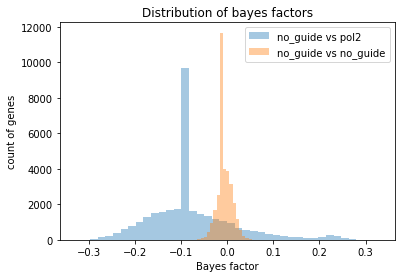

In [541]:
sns.distplot(res1, bins=40, kde=False);
sns.distplot(res2, bins=20, kde=False);
plt.legend(['no_guide vs pol2', 'no_guide vs no_guide']);
plt.title('Distribution of bayes factors');
plt.xlabel('Bayes factor');
plt.ylabel('count of genes');